In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
classes = ['ac', 'pi', 'os', 'oe', 'oa']

In [3]:
d3 = pd.DataFrame(
    [
        {'x': 'ac', 'y': 'pi', 'stats': (4, 0.83)},
        {'x': 'pi', 'y': 'os', 'stats': (4, 0.33)},
        {'x': 'os', 'y': 'oe', 'stats': (4, 0.18)},
        {'x': 'oe', 'y': 'oa', 'stats': (0, 0.87)}
    ]
)
d3

,x,y,stats
0,ac,pi,"(4, 0.83)"
1,pi,os,"(4, 0.33)"
2,os,oe,"(4, 0.18)"
3,oe,oa,"(0, 0.87)"


In [13]:
N = 1000

def get_project(N = N, d3 = d3, event = 'ac'): 
    r = d3.loc[d3.x == event]
    y = r['y'].values[0]
    l, v = r['stats'].values[0]
    
    print(f'{y} : {np.floor(v*N)}')
    
    return get_project(N = v*N, d3 = d3, event = y)
    
    
        
        
get_project()

pi : 830.0
os : 273.0
oe : 49.0
oa : 42.0


IndexError: index 0 is out of bounds for axis 0 with size 0

In [1]:
from models import ROAM
import random
import joblib
from scipy.stats import gamma, poisson, randint, binom, bernoulli, multinomial, norm, expon

co_model = joblib.load("./models/general_co_model.joblib")


In [4]:
random.seed(42)
prd = pd.date_range(start = pd.to_datetime('01/01/2023'), end = pd.to_datetime('12/31/2023'), freq = 'W')
sourcing_list = pd.DataFrame(
    data = {
        'date': prd, 'n_acs': 0
        }
)
sourcing_list.loc[0, 'n_acs'] = 1e6

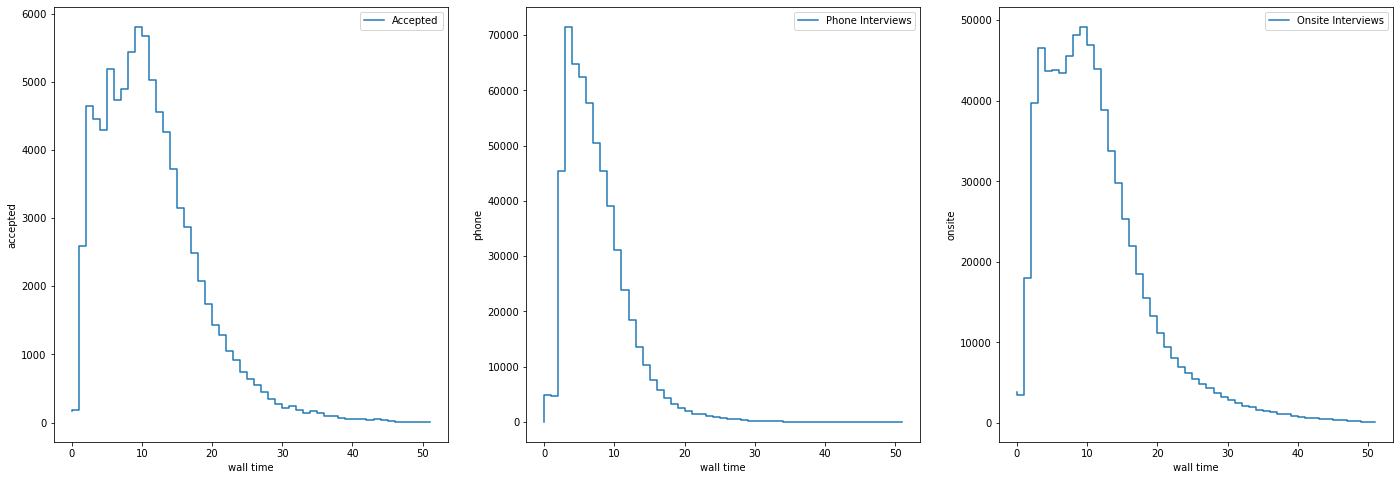

In [5]:
capacity_list = np.ones(52)
capacity_list[:] = 1e8

# capacity_list[20:30] = capacity_list[20:30] * 0. # capacity drops down to 100
# capacity_list[29:] = capacity_list[29:] * 0.5

OA = ROAM.simple_scheduler(individual_oa_model = co_model, feature_list = ['SWE', 'non-SWE', 'APAC', 'Americas', 'EMEA', 'week'],
                      sourcing_list = sourcing_list, job = 'SWE', location = 'APAC',
                      os_interview_capacity=capacity_list, tps_interview_capacity = capacity_list, sim_duration=52)


OA_df = pd.DataFrame(OA)

accepted = OA_df.groupby(['wall time'], as_index = False).agg(
    accepted = ('accepted', 'sum'),
    phone = ('phone', 'sum'),
    onsite = ('rejected', 'sum'),

    # backlog = ('backlog', 'mean'),
)

accepted = accepted.assign(
    accepted_cum = accepted.accepted.cumsum(),
    # latency =  (accepted.backlog / accepted.accepted) ** (1)
)




fig, ax = plt.subplots(figsize = (24, 8), ncols = 3)

ymin = 0
ymax = 16000

sns.lineplot(data = accepted, x = 'wall time', y = 'accepted', drawstyle = 'steps-pre', ax = ax[0], label = 'Accepted')
#ax[0].set_ylim([ymin, ymax])

sns.lineplot(data = accepted, x = 'wall time', y = 'phone', ax = ax[1], drawstyle = 'steps-pre', label = 'Phone Interviews')
#ax[1].set_ylim([ymin, ymax])

sns.lineplot(data = accepted, x = 'wall time', y = 'onsite', ax = ax[2], drawstyle = 'steps-pre', label = 'Onsite Interviews',)
# ax[1].set_ylim([ymin, ymax])

plt.show()

<AxesSubplot:xlabel='wall time'>

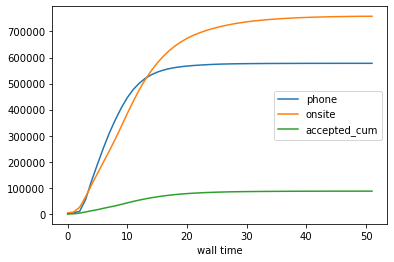

In [6]:
accepted.assign(
    phone = accepted.phone.cumsum(), 
    onsite = accepted.onsite.cumsum()
).plot(x = 'wall time', y = ['phone', 'onsite', 'accepted_cum'])

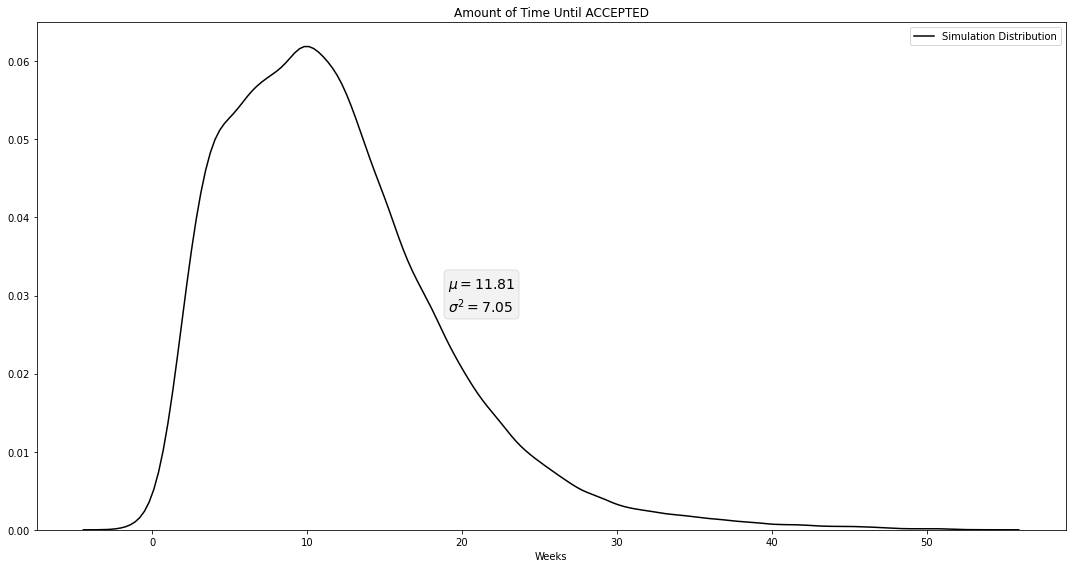

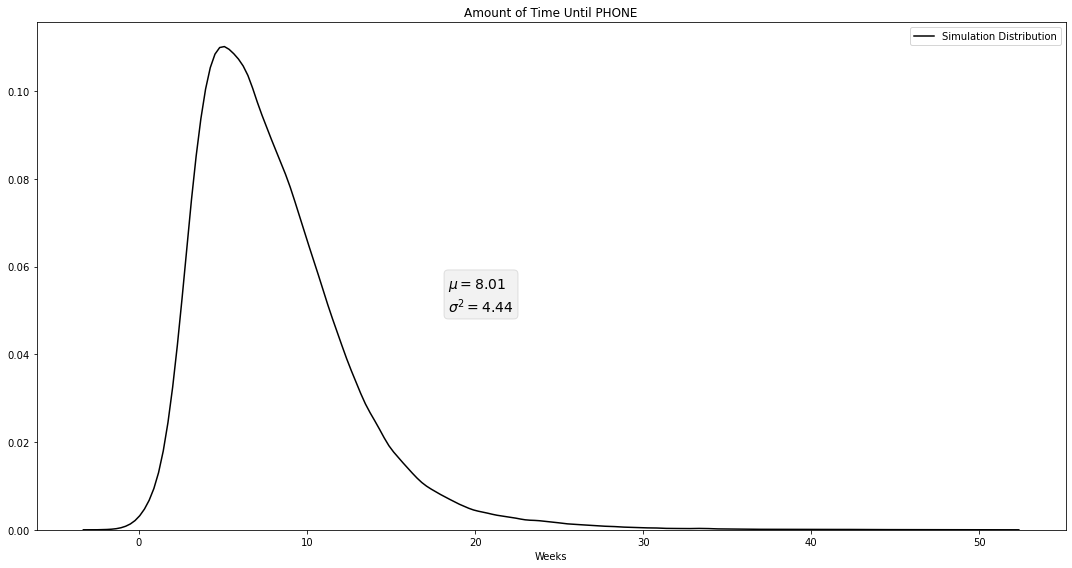

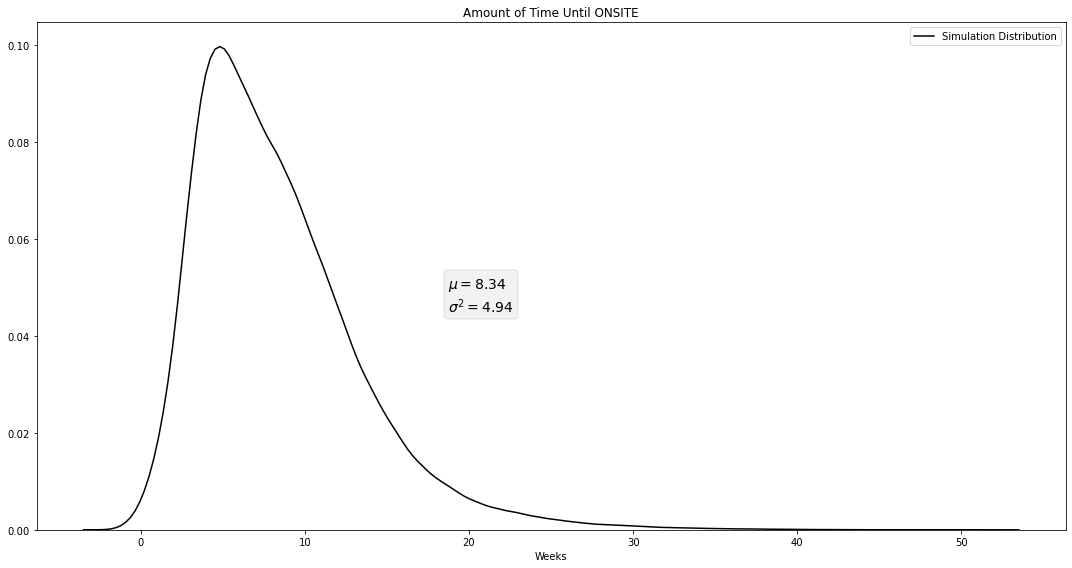

In [34]:

job = 'SWE'
location = 'APAC'


OA = ROAM.simple_scheduler(individual_oa_model = co_model, feature_list = ['SWE', 'non-SWE', 'APAC', 'Americas', 'EMEA', 'week'],
                      sourcing_list = sourcing_list, job = job, location = location,
                      os_interview_capacity=capacity_list, tps_interview_capacity = capacity_list, sim_duration=52)

OA_df = pd.DataFrame(OA)

accepted = OA_df.groupby(['wall time'], as_index = False).agg(
    accepted = ('accepted', 'sum'),
    phone = ('phone', 'sum'),
    onsite = ('onsite', 'sum'),


    # backlog = ('backlog', 'mean'),
)

accepted = accepted.assign(
    accepted_cum = accepted.accepted.cumsum(),
    # latency =  (accepted.backlog / accepted.accepted) ** (1)
)
for item, jtem in zip(['ACCEPTED', 'PHONE', 'ONSITE'], ['accepted', 'phone', 'onsite']):
    fig, ax = plt.subplots(figsize = (15, 8))
    #d = candidates_long.loc[(candidates_long.current_outcome == item) & (candidates_long[job] == 1) & (candidates_long[location] == 1)]['week']
    samples = accepted.apply(lambda row: int(row[jtem]) * [row['wall time']], axis = 1).explode().dropna().values
    
    #sns.histplot(d, stat = 'probability', binwidth=1, bins = 10, ax = ax, label = 'Observed Distribution')
    # sns.kdeplot(expon.rvs(d.mean(), 1, len(samples)), label = 'Exponential Distribution', ax = ax, color = 'black')
#     textstr = '\n'.join((
#       r'$\mu=%.2f$' % (d.mean(), ),
#       r'$\sigma^2=%.2f$' % (d.std(), )))
    
    props = dict(boxstyle='round', facecolor='b', alpha=0.1)
    
    # place a text box in upper left in axes coords
#     ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
#           verticalalignment='top', bbox=props)
    
    textstr = '\n'.join((
      r'$\mu=%.2f$' % (samples.mean(), ),
      r'$\sigma^2=%.2f$' % (samples.std(), )))
    
    props = dict(boxstyle='round', facecolor='grey', alpha=0.1)
    
    ax.text(0.40, 0.50, textstr, transform=ax.transAxes, fontsize=14,
          verticalalignment='top', bbox=props)

    sns.kdeplot(samples + norm.rvs(0, 1, len(samples)), label = 'Simulation Distribution',  ax = ax, color = 'black')
    ax.set_ylabel('')
    ax.set_xlabel('Weeks')
    ax.set_title(f'Amount of Time Until {item}')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

In [69]:
pipeline = pd.DataFrame(dict(
    Stage = ['Application Created', 'Phone Interview', 'Onsite Interview', 'Offer Extended', 'Offer Accepted'],
    Count = [200, 300, 500, 200, 40], 
    Lat = [4, 4, 4, 0, 0]
))
pipeline['n_weeks'] = pipeline.apply(lambda row: poisson(row['Lat'], 1).rvs(row['Count']), axis = 1)
pipeline.explode('n_weeks')

,Stage,Count,Lat,n_weeks
0,Application Created,200,4,4
0,Application Created,200,4,7
0,Application Created,200,4,4
0,Application Created,200,4,4
0,Application Created,200,4,5
...,...,...,...,...
4,Offer Accepted,40,0,1
4,Offer Accepted,40,0,1
4,Offer Accepted,40,0,1
4,Offer Accepted,40,0,1


In [70]:
sourcing_list

,date,n_acs
0,2023-01-01,1000000
1,2023-01-08,0
2,2023-01-15,0
3,2023-01-22,0
4,2023-01-29,0
5,2023-02-05,0
6,2023-02-12,0
7,2023-02-19,0
8,2023-02-26,0
9,2023-03-05,0


In [7]:
import pandas as pd
import numpy as np
import secrets


candidates = pd.read_csv('co_model - General_in_progress.csv')

candidates['application_create_week'] = pd.to_datetime(candidates['application_create_week'])

# we had to aggregate the data so that it could be brought into sheets.
duplicate_rows = []

for i, j in candidates.iterrows(): 
    for k in range(j['N']): 
        duplicate_rows.append(j.to_dict())
        
all_candidates = pd.DataFrame(duplicate_rows)

all_candidates['n_weeks'] = (all_candidates['application_closed_week'] + 1).apply(np.arange)
all_candidates['candidate_pid'] = all_candidates.apply(lambda row: secrets.token_hex(8), axis = 1) # assign a unique candidate identifier



In [9]:
candidates

,rpo_group,application_create_week,phone_interview,onsite_interview,offer_extended,offer_accepted,current_outcome,application_closed_week,N
0,India SWE Recruiting,2023-05-07,6.0,NaN,NaN,NaN,IN_PROGRESS,9,1
1,Cloud Americas Recruiting,2023-06-25,NaN,3.0,NaN,NaN,IN_PROGRESS,4,1
2,RSR EMEA SWE S09 Recruiting,2023-05-28,3.0,NaN,NaN,NaN,IN_PROGRESS,8,1
3,India Cloud Recruiting,2023-07-09,NaN,5.0,NaN,NaN,IN_PROGRESS,1,1
4,EMEA Intern Recruiting,2023-03-12,10.0,9.0,18.0,20.0,IN_PROGRESS,20,1
...,...,...,...,...,...,...,...,...,...
512,India SWE Recruiting,2022-03-20,NaN,10.0,NaN,NaN,IN_PROGRESS,46,1
513,EMEA Intern Recruiting,2023-06-25,3.0,NaN,5.0,5.0,IN_PROGRESS,5,1
514,India SWE Recruiting,2023-06-25,NaN,NaN,NaN,NaN,IN_PROGRESS,1,1
515,India SWE Recruiting,2023-04-16,NaN,NaN,13.0,13.0,IN_PROGRESS,13,1
